---------------------------------------------------------------
Question 1 - Preprocessing and testing on different feature extraction methods
---------------------------------------------------------------

In case need to download pandas and nltk and numpy

In [ ]:
%pip install nltk
%pip install pandas
%pip install numpy
%pip install scikit-learn
%pip install transformers
%pip install torch
%pip install matplotlib

Initial preprocessing - used in HW 0 and 1

In [93]:
# ----- PRE PROCESSING -----
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import BertTokenizer, BertModel
import torch
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2Model
from sklearn.decomposition import TruncatedSVD

nltk.download('punkt_tab')
nltk.download('stopwords')

# stemming tool from nltk
stemmer = PorterStemmer()
# a mapping dictionary that help remove punctuations
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
def get_tokens(text):
  # turn document into lowercase
  lowers = text.lower()
  # remove punctuations
  no_punctuation = lowers.translate(remove_punctuation_map)
  # tokenize document
  tokens = nltk.word_tokenize(no_punctuation)
  # remove stop words
  filtered = [w for w in tokens if not w in stopwords.words('english')]
  # stemming process
  stemmed = []
  for item in filtered:
    stemmed.append(stemmer.stem(item))
  # final unigrams
  return stemmed

traningData = pd.read_csv('24_train_3.csv', header='infer')
# Use HW 0  token filtering step
traningData['Processed_Text'] = traningData['Text'].apply(lambda x: ' '.join(get_tokens(str(x))))
traningData

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nsano\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nsano\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,ArticleId,Text,Category,Processed_Text
0,1429,sfa awaits report over mikoliunas the scottish...,sport,sfa await report mikoliuna scottish footbal as...
1,1896,parmalat to return to stockmarket parmalat th...,business,parmalat return stockmarket parmalat italian d...
2,1633,edu blasts arsenal arsenal s brazilian midfiel...,sport,edu blast arsen arsen brazilian midfield edu h...
3,2178,henman decides to quit davis cup tim henman ha...,sport,henman decid quit davi cup tim henman retir gr...
4,194,french suitor holds lse meeting european stock...,business,french suitor hold lse meet european stock mar...
...,...,...,...,...
995,1250,blair damaged by blunkett row a majority of ...,politics,blair damag blunkett row major voter 68 believ...
996,1639,a november to remember last saturday one news...,sport,novemb rememb last saturday one newspap procla...
997,916,highbury tunnel players in clear the football ...,sport,highburi tunnel player clear footbal associ sa...
998,2217,top stars join us tsunami tv show brad pitt r...,entertainment,top star join us tsunami tv show brad pitt rob...



Question 1 - Feature extraction methods - 4 methods, TFIDF, CountVectorizer, BERT, GPT
---------------------------------------------------------------

TFIDF method

In [94]:
# ----------- TfidfVectorizer method - convert to number - use TFIDF value -----------
tfidf_vectorizer = TfidfVectorizer() # like hw 1
X_tfidf = tfidf_vectorizer.fit_transform(traningData['Processed_Text'])

Bigram and Unigram method

In [95]:
# ----------- Bigram Unigram method - cnovert words into matrix of word counts -----------
count_vectorizer = CountVectorizer(ngram_range=(1, 2))  # shape = 1000, 181043 -- 181043 unique words and bigrams for all text
X_count = count_vectorizer.fit_transform(traningData['Processed_Text'])

BERT Embedding method

In [96]:
# ----------- Bert method - convert words into vector -----------
# load bert model and tokenizer
device = torch.device("cpu")
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

def get_bert_embedding(text):
  # turn text into tokens
  inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
  with torch.no_grad():
    outputs = bert_model(**inputs) # send tokens to get embeddings
  return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

X_bert_list = []
for text in traningData['Processed_Text']:
  # get bert embedding for each text
  bert_embedding = get_bert_embedding(text)
  X_bert_list.append(bert_embedding)

X_bert = np.array(X_bert_list)

GPT2 Embedding method

In [97]:
# ----------- GPT method - convert words into vector -----------
gpt_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt_embedding_model = GPT2Model.from_pretrained("gpt2")

gpt_tokenizer.pad_token = gpt_tokenizer.eos_token

def get_gpt_embedding(text):
  #turn text into tokens
  inputs = gpt_tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
  with torch.no_grad():
    outputs = gpt_embedding_model(**inputs) # turn input tokens to vectors
  return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

X_gpt_list = []
for text in traningData['Processed_Text']:
  # get gpt embedding for each text
  gpt_embedding = get_gpt_embedding(text)
  X_gpt_list.append(gpt_embedding)

X_gpt = np.array(X_gpt_list)

LSA mthod - uses TFIDF matrix

In [98]:
# ----------- LSA - convert words into vector -----------
# need to use tfidf, use TruncatedSVD
lsa_model = TruncatedSVD(n_components=100)
X_lsa = lsa_model.fit_transform(X_tfidf)

Question 1 - Train NN on each of the features
---------------------------------------------------------------

In [99]:
# Question 1 Part 1 - Accuracy of each feature method

features = {
    "TFIDF": X_tfidf,
    "CountVectorizer": X_count,
    "BERT": X_bert,
    "GPT": X_gpt,
    "LSA": X_lsa,
}

# initilaize model here
feature_nn_model = MLPClassifier(hidden_layer_sizes=(32, 32), max_iter=500)

# store results here
feature_results = []
for method, X in features.items():
    # 5 fold cross validation
    cross_val = StratifiedKFold(n_splits=5, shuffle=True)

    expectedData = traningData['Category']
    train_accuracies = []
    val_accuracies = []
    # for each split, get train and val accuracies
    for train_index, val_index in cross_val.split(X, expectedData):
        # split
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = expectedData.iloc[train_index], expectedData.iloc[val_index]
        
        # fit
        feature_nn_model.fit(X_train, y_train)
        
        # get accuracies
        train_accuracies.append(feature_nn_model.score(X_train, y_train))
        val_accuracies.append(feature_nn_model.score(X_val, y_val))

    train_mean = np.mean(train_accuracies)
    train_std = np.std(train_accuracies)
    val_mean = np.mean(val_accuracies)
    val_std = np.std(val_accuracies)

    feature_results.append({
        'Feature Method': method,
        'Training Accuracy Mean': train_mean,
        'Training Accuracy Std': train_std,
        'Validation Accuracy Mean': val_mean,
        'Validation Accuracy Std': val_std
    })

feature_results_df = pd.DataFrame(feature_results)

print("| Feature Method | Training Accuracy Mean | Training STDs | Validation Accuracy | Validation STDs |")
print("|----------------|------------------------|---------------|---------------------|-----------------|")
for i, value in enumerate(feature_results_df['Feature Method']):
    training_means = feature_results_df['Training Accuracy Mean']
    training_stds = feature_results_df['Training Accuracy Std']
    validation_means = feature_results_df['Validation Accuracy Mean']
    validation_stds = feature_results_df['Validation Accuracy Std']
    print(f"| {value:<18} | {training_means[i]:<22.4f} | {training_stds[i]:<13.4f} | {validation_means[i]:<19.4f} | {validation_stds[i]:<15.4f} |")


| Feature Method | Training Accuracy Mean | Training STDs | Validation Accuracy | Validation STDs |
|----------------|------------------------|---------------|---------------------|-----------------|
| TFIDF              | 1.0000                 | 0.0000        | 0.9750              | 0.0105          |
| CountVectorizer    | 1.0000                 | 0.0000        | 0.9670              | 0.0093          |
| BERT               | 1.0000                 | 0.0000        | 0.9660              | 0.0073          |
| GPT                | 1.0000                 | 0.0000        | 0.9630              | 0.0103          |
| LSA                | 1.0000                 | 0.0000        | 0.9580              | 0.0093          |


Plot results

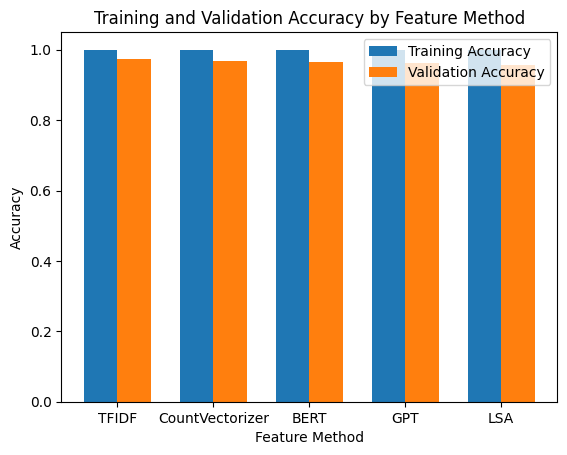

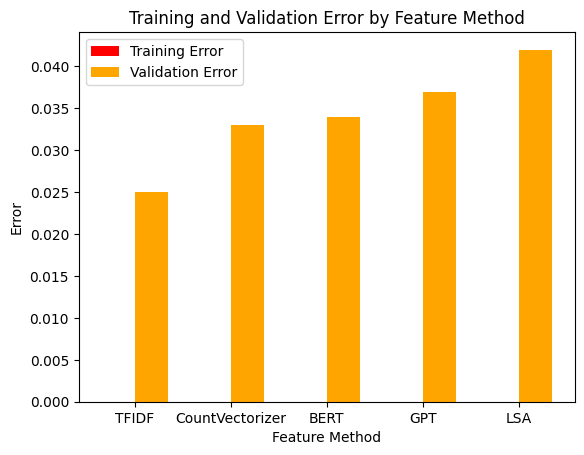

In [100]:
# plotting function for both train and val accuracy and their error
def plot(results_df, variable_name):
    variable = results_df[variable_name]
    training_accuracies = results_df["Training Accuracy Mean"]
    validation_accuracies = results_df["Validation Accuracy Mean"]
    training_errors = 1 - training_accuracies
    validation_errors = 1 - validation_accuracies

    # Plotting accuracy
    x = np.arange(len(variable))
    width = 0.35

    figure, plot_acc = plt.subplots()

    plot_acc.bar(x - width/2, training_accuracies, width, label='Training Accuracy')
    plot_acc.bar(x + width/2, validation_accuracies, width, label='Validation Accuracy')

    plot_acc.set_ylabel('Accuracy')
    plot_acc.set_title(f'Training and Validation Accuracy by {variable_name}')
    plot_acc.set_xticks(x)
    plot_acc.set_xticklabels(variable)
    plot_acc.set_xlabel(variable_name)
    plot_acc.legend()

    # Plotting error
    figure, plot_err = plt.subplots()

    plot_err.bar(x - width/2, training_errors, width, label='Training Error', color='red')
    plot_err.bar(x + width/2, validation_errors, width, label='Validation Error', color='orange')

    plot_err.set_ylabel('Error')
    plot_err.set_title(f'Training and Validation Error by {variable_name}')
    plot_err.set_xticks(x)
    plot_err.set_xticklabels(variable)
    plot_err.set_xlabel(variable_name)
    plot_err.legend()

    plt.show()
plot(feature_results_df, 'Feature Method')

After multiple runs, BERT and TFIDF are more consistently the ones with the least error rate. CountVectorizer is not consistent. Will move forward with TFIDF since it had the least

---------------------------------------------------------------
Question 2 - Testing on different learning rates
---------------------------------------------------------------

Question 2 - Learning rates
I used 32x32 hidden layer size, a larger one is not needed as the results are not too different and it takes less computation time
max-iteration of 500 for convergence rate
Learning rates of the ones listed in the instructions
Using TFIDF embedding since it performed the most consistently

| Learning Rate | Training Accuracy Mean | Training STDs | Validation Accuracy | Validation STDs |
|---------------|------------------------|---------------|---------------------|-----------------|
| 0.0001        | 1.0000                 | 0.0000        | 0.9680              | 0.0178          |
| 0.0003        | 1.0000                 | 0.0000        | 0.9720              | 0.0040          |
| 0.001         | 1.0000                 | 0.0000        | 0.9670              | 0.0133          |
| 0.003         | 1.0000                 | 0.0000        | 0.9700              | 0.0118          |
| 0.01          | 1.0000                 | 0.0000        | 0.9710              | 0.0139          |
| 0.03          | 1.0000                 | 0.0000        | 0.9400              | 0.0184          |
| 0.1           | 1.0000                 | 0.0000        | 0.9370              | 0.0172          |


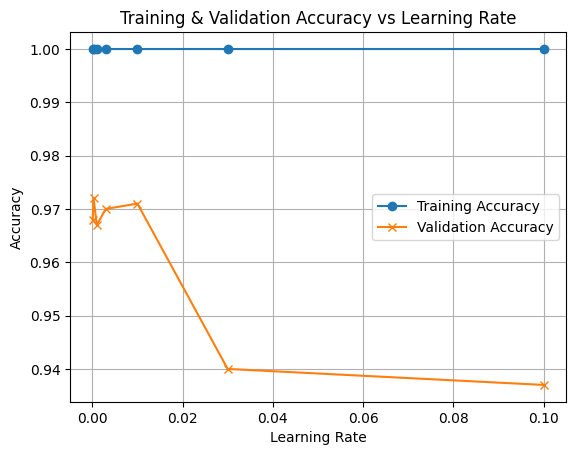

In [101]:
# Learning rate

X = X_tfidf  # best feature method from q1
y = traningData['Category']

learning_rates = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]

lr_cross_val = StratifiedKFold(n_splits=5, shuffle=True)

# store results here
lr_results = []
for lr in learning_rates:
    # 5 fold cross validation
    train_accuracies = []
    val_accuracies = []
    
    # for each split, get train and val accuracies
    for train_index, val_index in lr_cross_val.split(X, expectedData):
        # split
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = expectedData.iloc[train_index], expectedData.iloc[val_index]

        # initialize model here with learning rate
        nn_model = MLPClassifier(hidden_layer_sizes=(32, 32), max_iter=500, learning_rate_init=lr)
        
        # fit
        nn_model.fit(X_train, y_train)
        
        # get accuracies
        train_accuracies.append(nn_model.score(X_train, y_train))
        val_accuracies.append(nn_model.score(X_val, y_val))

    train_mean = np.mean(train_accuracies)
    train_std = np.std(train_accuracies)
    val_mean = np.mean(val_accuracies)
    val_std = np.std(val_accuracies)

    lr_results.append({
        'Learning Rate': lr,
        'Training Accuracy Mean': train_mean,
        'Training Accuracy Std': train_std,
        'Validation Accuracy Mean': val_mean,
        'Validation Accuracy Std': val_std
    })

lr_results_df = pd.DataFrame(lr_results)
print("| Learning Rate | Training Accuracy Mean | Training STDs | Validation Accuracy | Validation STDs |")
print("|---------------|------------------------|---------------|---------------------|-----------------|")
for i, value in enumerate(lr_results_df['Learning Rate']):
    training_means = lr_results_df['Training Accuracy Mean']
    training_stds = lr_results_df['Training Accuracy Std']
    validation_means = lr_results_df['Validation Accuracy Mean']
    validation_stds = lr_results_df['Validation Accuracy Std']
    print(f"| {value:<13} | {training_means[i]:<22.4f} | {training_stds[i]:<13.4f} | {validation_means[i]:<19.4f} | {validation_stds[i]:<15.4f} |")

# Now plot - needs to be line graph
fig, plot_lr = plt.subplots()

# Training and validation acc
plot_lr.plot(lr_results_df['Learning Rate'], lr_results_df['Training Accuracy Mean'], label='Training Accuracy', marker='o')
plot_lr.plot(lr_results_df['Learning Rate'], lr_results_df['Validation Accuracy Mean'], label='Validation Accuracy', marker='x')

# labels and title
plot_lr.set_xlabel('Learning Rate')
plot_lr.set_ylabel('Accuracy')
plot_lr.set_title('Training & Validation Accuracy vs Learning Rate')
plot_lr.legend()

plot_lr.grid(True)
plt.show()


Question 2 - Testing on different optimizers
---------------------------------------------------------------

c:\Users\nsano\source\repos\CSE572HW2\cse572\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\nsano\source\repos\CSE572HW2\cse572\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\nsano\source\repos\CSE572HW2\cse572\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\nsano\source\repos\CSE572HW2\cse572\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warning

| Optimizer | Training Accuracy Mean | Training STDs | Validation Accuracy | Validation STDs |
|-----------|------------------------|---------------|---------------------|-----------------|
| adam      | 1.0000                 | 0.0000        | 0.9700              | 0.0122          |
| sgd       | 0.6725                 | 0.0978        | 0.6110              | 0.0835          |
| lbfgs     | 1.0000                 | 0.0000        | 0.9520              | 0.0169          |


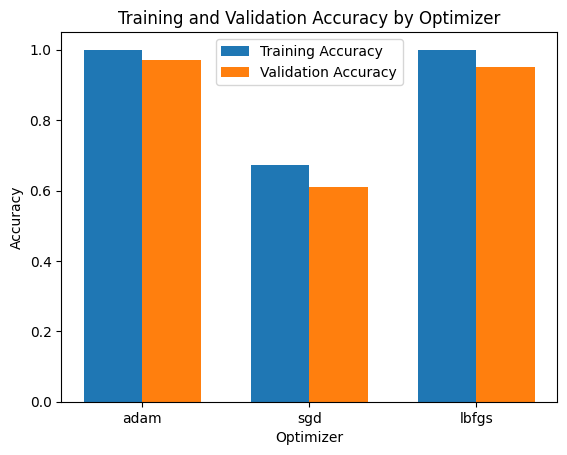

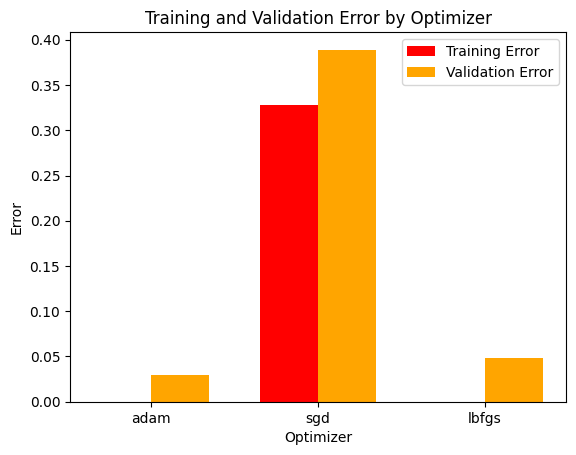

In [102]:
# Optimizers

X = X_tfidf  # best feature method from q1
y = traningData['Category']

optimizer_cross_val = StratifiedKFold(n_splits=5, shuffle=True)


# list of optimzers to test
optimizers = ['adam', 'sgd', 'lbfgs']


optimizer_results = []
for optimizer in optimizers:
    # 5 fold cross validation
    train_accuracies = []
    val_accuracies = []
    
    # for each split, get train and val accuracies
    for train_index, val_index in optimizer_cross_val.split(X, expectedData):
        # split
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = expectedData.iloc[train_index], expectedData.iloc[val_index]

        # initialize model here with learning rate
        nn_model = MLPClassifier(hidden_layer_sizes=(32, 32), max_iter=500, solver=optimizer)
        
        # fit
        nn_model.fit(X_train, y_train)
        
        # get accuracies
        train_accuracies.append(nn_model.score(X_train, y_train))
        val_accuracies.append(nn_model.score(X_val, y_val))

    train_mean = np.mean(train_accuracies)
    train_std = np.std(train_accuracies)
    val_mean = np.mean(val_accuracies)
    val_std = np.std(val_accuracies)

    optimizer_results.append({
        'Optimizer': optimizer,
        'Training Accuracy Mean': train_mean,
        'Training Accuracy Std': train_std,
        'Validation Accuracy Mean': val_mean,
        'Validation Accuracy Std': val_std
    })

optimizer_results_df = pd.DataFrame(optimizer_results)
print("| Optimizer | Training Accuracy Mean | Training STDs | Validation Accuracy | Validation STDs |")
print("|-----------|------------------------|---------------|---------------------|-----------------|")
for i, value in enumerate(optimizer_results_df['Optimizer']):
    training_means = optimizer_results_df['Training Accuracy Mean']
    training_stds = optimizer_results_df['Training Accuracy Std']
    validation_means = optimizer_results_df['Validation Accuracy Mean']
    validation_stds = optimizer_results_df['Validation Accuracy Std']
    print(f"| {value:<9} | {training_means[i]:<22.4f} | {training_stds[i]:<13.4f} | {validation_means[i]:<19.4f} | {validation_stds[i]:<15.4f} |")

plot(optimizer_results_df, "Optimizer")


---------------------------------------------------------------
Question 3 - Preprocess and get features
---------------------------------------------------------------

Preprocessing steps, same as before, and using BERT

In [ ]:
# load testing data
testingData = pd.read_csv('news-test-1.csv', header='infer')
testingData['Processed_Text'] = testingData['Text'].apply(lambda x: ' '.join(get_tokens(str(x))))

test_tfidf_vectorizer = TfidfVectorizer()
X_train = test_tfidf_vectorizer.fit_transform(traningData['Processed_Text'])
X_test = test_tfidf_vectorizer.transform(testingData['Processed_Text'])

X_train_q3 = X_train.toarray()
X_test_q3 = X_test.toarray()

Question 3 - Predict the labels for the testing data
---------------------------------------------------------------

Train the model here using training data and then predict, print, and save

In [105]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neural_network import MLPClassifier
import numpy as np


nn_model = MLPClassifier(hidden_layer_sizes=(32, 32), max_iter=500, solver='adam', learning_rate_init=0.001)

# 5 fold cross validation
test_cross_val = StratifiedKFold(n_splits=5, shuffle=True)

expectedData = traningData['Category']

final_train_accuracies = []
final_val_accuracies = []
# for each split, get train and val accuracies
for train_index, val_index in test_cross_val.split(X_train_q3, expectedData):
    # split
    X_train, X_val = X_train_q3[train_index], X_train_q3[val_index]
    y_trin, y_val = expectedData.iloc[train_index], expectedData.iloc[val_index]
    
    # fit
    nn_model.fit(X_train, y_trin)
    
    # get accuracies
    final_train_accuracies.append(nn_model.score(X_train, y_trin))
    final_val_accuracies.append(nn_model.score(X_val, y_val))

train_mean = np.mean(final_train_accuracies)
train_std = np.std(final_train_accuracies)
val_mean = np.mean(final_val_accuracies)
val_std = np.std(final_val_accuracies)

print(f"Training Accuracy Mean: {train_mean}, Training Accuracy Std: {train_std}")
print(f"Validation Accuracy Mean: {val_mean}, Validation Accuracy Std: {val_std}")

# make the prediction
predictions = nn_model.predict(X_test_q3)

predicted_labels = pd.DataFrame({
    'ArticleId': testingData['ArticleId'],
    'Predicted Category': predictions
})
# save to csv
predicted_labels.to_csv('labels.csv', header=False, index=False, columns=['ArticleId', 'Predicted Category'])
print(predicted_labels.head())


Training Accuracy Mean: 1.0, Training Accuracy Std: 0.0
Validation Accuracy Mean: 0.9710000000000001, Validation Accuracy Std: 0.006633249580710806
   ArticleId Predicted Category
0       1225           business
1       1576      entertainment
2       1353           business
3       1138              sport
4       1915           politics
